<a href="https://colab.research.google.com/github/Matrixmax/Dive_into_DeepLearning/blob/main/0x31_%E6%AE%8B%E5%B7%AE%E7%BD%91%E7%BB%9C%EF%BC%88ResNet%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

让我们先思考一个问题：对神经网络模型添加新的层，充分训练后的模型是否只可能更有效地降低训练误差？理论上，原模型解的空间只是新模型解的空间的子空间。也就是说，如果我们能将新添加的层训练成恒等映射f(x) = x，新模型和原模型将同样有效。由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。然而在实践中，添加过多的层后训练误差往往不降反升。即使利用批量归一化带来的数值稳定性使训练深层模型更加容易，该问题仍然存在。针对这一问题，何恺明等人提出了残差网络（ResNet） [1]。它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。

## 1. 残差块
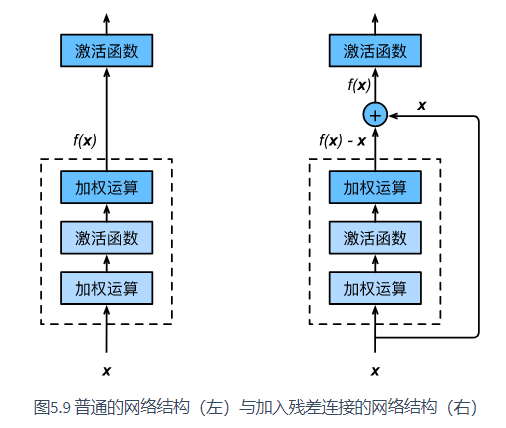

让我们聚焦于神经网络局部。如图5.9所示，设输入为x。假设我们希望学出的理想映射为)f(x)，从而作为图5.9上方激活函数的输入。左图虚线框中的部分需要直接拟合出该映射f(x)，而右图虚线框中的部分则需要拟合出有关恒等映射的残差映射f(x)−x。残差映射在实际中往往更容易优化。以本节开头提到的恒等映射作为我们希望学出的理想映射f(x)。我们只需将图5.9中右图虚线框内上方的加权运算（如仿射）的权重和偏差参数学成0，那么f(x)即为恒等映射。实际中，当理想映射f(x)极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。图5.9右图也是ResNet的基础块，即残差块（residual block）。在残差块中，输入可通过跨层的数据线路更快地向前传播。

ResNet沿用了VGG全3×3卷积层的设计。残差块里首先有2个有相同输出通道数的3×3卷积层。每个卷积层后接一个批量归一化层和ReLU激活函数。然后我们将输入跳过这两个卷积运算后直接加在最后的ReLU激活函数前。这样的设计要求两个卷积层的输出与输入形状一样，从而可以相加。如果想改变通道数，就需要引入一个额外的1×1卷积层来将输入变换成需要的形状后再做相加运算。

残差块的实现如下。它可以设定输出通道数、是否使用额外的1×1卷积层来修改通道数以及卷积层的步幅。

In [15]:
import time
import torch
from torch import nn,optim
import torch.nn.functional as F
import sys
import d2lzh_pytorch as d2l

from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Colab Notebooks/Dive_Into_Deep_Learning')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Wed Feb 17 13:08:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
class Residual(nn.Module):
    def __init__(self,in_channels,out_channels,use_1x1conv=False,stride=1):
        super(Residual,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,stride=stride)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self,X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return F.relu(Y+X)

In [9]:
# 下面我们来查看输入和输出形状一致的情况。
blk = Residual(3,3)
X = torch.rand((4,3,6,6))
blk(X).shape #torch.Size([4,3,6,6])

torch.Size([4, 3, 6, 6])

In [11]:
# 我们也可以在增加输出通道数的同时减半输出的高和宽。
blk = Residual(3,6,use_1x1conv=True,stride=2)
blk(X).shape #torch.Size([4, 6, 3, 3])


torch.Size([4, 6, 3, 3])

## 2. ResNet模型
ResNet的前两层跟之前介绍的GoogLeNet中的一样：在输出通道数为64、步幅为2的7×7卷积层后接步幅为2的3×3的最大池化层。不同之处在于ResNet每个卷积层后增加的批量归一化层。

In [12]:
net = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
)

GoogLeNet在后面接了4个由Inception块组成的模块。ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大池化层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，这里对第一个模块做了特别处理。

In [13]:
def resnet_block(in_channels,out_channels,num_residuals,first_block=False):
    if first_block:
        assert in_channels == out_channels# 第一个模块的通道数同输入通道数一致
    blk = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blk.append(Residual(in_channels,out_channels,use_1x1conv=True,stride=2))
        else:
            blk.append(Residual(out_channels,out_channels))
    return nn.Sequential(*blk)

In [16]:
# 接着我们为ResNet加入所有残差块。这里每个模块使用两个残差块。
net.add_module("resnet_block1", resnet_block(64, 64, 2, first_block=True))
net.add_module("resnet_block2", resnet_block(64, 128, 2))
net.add_module("resnet_block3", resnet_block(128, 256, 2))
net.add_module("resnet_block4", resnet_block(256, 512, 2))


In [17]:
# 最后，与GoogLeNet一样，加入全局平均池化层后接上全连接层输出。
net.add_module('global_avg_pool',d2l.GlobalAvgPool2d()) # GlobalAvgPool2d的输出: (Batch, 512, 1, 1)
net.add_module("fc",nn.Sequential(d2l.FlattenLayer(), nn.Linear(512, 10)))

这里每个模块里有4个卷积层（不计算1×1卷积层），加上最开始的卷积层和最后的全连接层，共计18层。这个模型通常也被称为ResNet-18。通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。虽然ResNet的主体架构跟GoogLeNet的类似，但ResNet结构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。

在训练ResNet之前，我们来观察一下输入形状在ResNet不同模块之间的变化。

In [18]:
X = torch.rand((1, 1, 224, 224))
for name, layer in net.named_children():
    X = layer(X)
    print(name, ' output shape:\t', X.shape)


0  output shape:	 torch.Size([1, 64, 112, 112])
1  output shape:	 torch.Size([1, 64, 112, 112])
2  output shape:	 torch.Size([1, 64, 112, 112])
3  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block1  output shape:	 torch.Size([1, 64, 56, 56])
resnet_block2  output shape:	 torch.Size([1, 128, 28, 28])
resnet_block3  output shape:	 torch.Size([1, 256, 14, 14])
resnet_block4  output shape:	 torch.Size([1, 512, 7, 7])
global_avg_pool  output shape:	 torch.Size([1, 512, 1, 1])
fc  output shape:	 torch.Size([1, 10])


## 3.获取数据和训练模型

In [19]:
batch_size = 256
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
d2l.train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs)


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw


Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


training on  cuda
epoch 1, loss 0.3920, train acc 0.856, test acc 0.868, time 45.1 sec
epoch 2, loss 0.2486, train acc 0.908, test acc 0.907, time 47.4 sec
epoch 3, loss 0.2090, train acc 0.923, test acc 0.890, time 50.2 sec
epoch 4, loss 0.1815, train acc 0.933, test acc 0.911, time 49.3 sec
epoch 5, loss 0.1580, train acc 0.941, test acc 0.898, time 49.9 sec
